In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
from src.emfiles import get_data_from_df
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
import mrcfile

### Read the data

In [3]:
data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
star_file = "job550_particles_roy40k.star"

#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"


#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

df = star.parse_star(data_dir + star_file, keep_index = False)

imgs, pixel_size, angles, shifts, ctf_params = get_data_from_df(df, data_dir)



/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


In [4]:
imgs_orig = imgs

print(imgs_orig.shape)
print(pixel_size.shape)
print(angles.shape)
print(shifts.shape)
print(ctf_params.shape)

(39972, 308, 308)
(39972,)
(39972, 3)
(39972, 2)
(39972, 9)


In [33]:
imgs = imgs_orig[:,128-32:128+32, 128-32:128+32]

In [34]:
nx = imgs.shape[-1]
N = imgs.shape[0]

In [35]:
imgs.shape

(39972, 64, 64)

In [36]:
imgs_f = np.fft.fft2(imgs)
imgs_f = imgs_f.reshape(imgs_f.shape[0], -1)
imgs_f.shape

(39972, 4096)

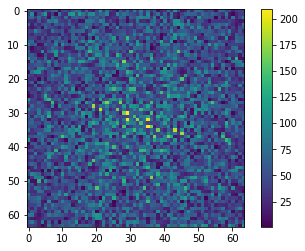

In [37]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[100].reshape(nx,nx)))); plt.colorbar()

### Create the grids

4096.0


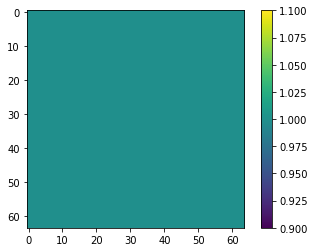

In [38]:
# Assume the pixel size is the same for all images
px = pixel_size[0]

x_freq = np.fft.fftfreq(nx, px)
y_freq = np.fft.fftfreq(nx, px)
z_freq = np.fft.fftfreq(nx, px)

# Important thast the grids are not jax (aka Tracer)  objects
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

X, Y, Z = jnp.meshgrid(x_freq,z_freq,y_freq)
mask = create_mask(X, Y, Z , (0,0,0),0.9)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

print(np.sum(mask[:,:,0]))

In [39]:
@jax.jit
def slice_func(v, angles, shifts, ctf_params):
    projection, _ = project(v, x_grid, y_grid, z_grid, angles, shifts, "tri", ctf_params)

    return projection

@jax.jit
def slice_func_array(v, angles, shifts, ctf_params):    
    return jax.vmap(slice_func, in_axes = (None, 0, 0, 0))(v, angles)

In [103]:
@jax.jit
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, shifts, ctf_params, img, alpha = 1):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    
    # With l2 regularization
    return 1/(2* nx*nx) * (alpha * l2sq(v) + l2sq(slice_func(v, angles, shifts, ctf_params) - img))
    #return 1/(2* 4096.0) * (alpha * l2sq(v) + l2sq(slice_func(v, angles, shifts, ctf_params) - img))



@jax.jit
def loss_func_batched(v, angles, shifts, ctf_params, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs)

@jax.jit
def loss_func_sum(v, angles, shifts, ctf_params, imgs):
    return jnp.mean(loss_func_batched(v, angles, shifts, ctf_params, imgs))

In [104]:
@jax.jit
def grad_loss_volume(v, angles, shifts, ctf_params, img):
    return jax.grad(loss_func)(v, angles, shifts, ctf_params, img)

@jax.jit
def grad_loss_volume_batched(v, angles, shifts, ctf_params, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs), axis=0)

@jax.jit
def grad_loss_volume_sum(v, angles, shifts, ctf_params, imgs):
    return jax.grad(loss_func_sum)(v, angles, shifts, ctf_params, imgs)



Test the functions above with a random volume

In [105]:
vf = jnp.array(np.random.randn(nx,nx,nx))

In [106]:
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(4096,)

In [107]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

1.2193453311920166
(64, 64, 64)


In [108]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

1.6857247352600098
(64, 64, 64)


### CG

In [109]:
from src.algorithm import conjugate_gradient

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 50
zero = jnp.zeros(v0.shape).astype(jnp.complex128)
Ab = - jnp.conj(grad_loss_volume_sum(zero, angles, shifts, ctf_params, imgs_f))
AA = lambda vv : jnp.conj(grad_loss_volume_sum(vv, angles, shifts, ctf_params, imgs_f)) + Ab

vcg, max_iter = conjugate_gradient(AA, Ab, v0, N_iter, verbose = True)



Iter 0 ||r|| = 0.00022236236379956085
Iter 1 ||r|| = 1.4906949662006745e-05
Iter 2 ||r|| = 6.643777593554843e-07
Iter 3 ||r|| = 2.5166999789263175e-08
Iter 4 ||r|| = 9.271861902527893e-10
Iter 5 ||r|| = 3.657457099774375e-11
Iter 6 ||r|| = 1.7489879607891213e-12
Iter 7 ||r|| = 1.0780804019209892e-13
Iter 8 ||r|| = 6.546313910125163e-15
Iter 9 ||r|| = 5.666675892392249e-15
Iter 10 ||r|| = 4.673275851721501e-15
Iter 11 ||r|| = 3.8192085148903155e-15
Iter 12 ||r|| = 2.8953957321842723e-15
Iter 13 ||r|| = 2.374096602270364e-15
Iter 14 ||r|| = 2.6592603726778567e-15
Iter 15 ||r|| = 2.7372828631223364e-15
Iter 16 ||r|| = 2.686730921065697e-15
Iter 17 ||r|| = 2.6329132873074945e-15
Iter 18 ||r|| = 2.4840596878591274e-15
Iter 19 ||r|| = 2.394118451254117e-15
Iter 20 ||r|| = 2.28912124914133e-15
Iter 21 ||r|| = 2.054018600049937e-15
Iter 22 ||r|| = 1.8696905846657006e-15
Iter 23 ||r|| = 1.7768736262425334e-15
Iter 24 ||r|| = 1.766535586475353e-15
Iter 25 ||r|| = 1.7610867451227998e-15
Iter 26 |

In [111]:
#for i in range(10):
#    vcg, max_iter = conjugate_gradient(AA, Ab, vcg*mask, N_iter, verbose = True)

In [112]:
#print("Final loss function = ", loss_func_sum(vcg, angles, shifts, ctf_params, imgs_f))

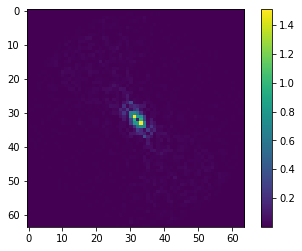

In [113]:
i = 12500
s0 = slice_func(vcg, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

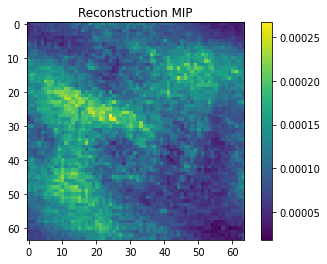

In [123]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [115]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg)))

In [118]:
vr.shape

(64, 64, 64)

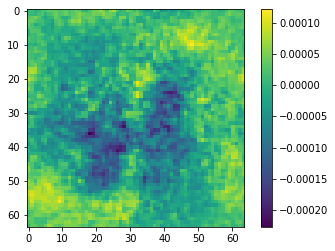

In [121]:
plt.imshow(vr[:,:,12]); plt.colorbar()

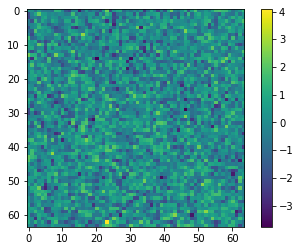

In [117]:
plt.imshow(imgs[i]); plt.colorbar()